# Ordinary Least Square

In [1]:
%matplotlib inline

In [2]:
#Data processing
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.reset_orig()
from Residual_Visualization import regression_residual_plots

#Machine Learning
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


#Helpers
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


-----------------

In [3]:
df = pd.read_csv("/Users/duc_hoang/Box Sync/Fermilab Summer Research/CNN-Architectural-Analysis/MINERvA-Vertex-Finding/Data/Combined-population/Combined-populations-with-labels.csv",
                 index_col = 0)

In [4]:
df = df.drop('group', axis=1)
#Select out the healthy parts
df = df[df["final_accuracy"] >= 0.100533]

Text(0.5, 1.0, 'Transformed Accuracy')

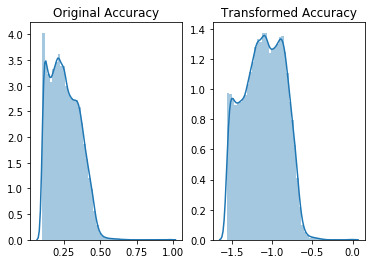

In [5]:
# normalize the exponential data with boxcox
normalized_accuracy = stats.boxcox(df["final_accuracy"])

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(df['final_accuracy'], ax=ax[0])
ax[0].set_title("Original Accuracy")
ax[0].set(xlabel='')
sns.distplot(normalized_accuracy[0], ax=ax[1])
ax[1].set_title("Transformed Accuracy")

In [6]:
df["transformed_accuracy"] = normalized_accuracy[0]

---------------

In [7]:
#Feature + target
X = df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy',"transformed_accuracy"]) #Features
y = df["transformed_accuracy"]

#Extract initial feature names and index for later use
initial_feature_names = X.columns #Save the feature names
initial_index = X.index

In [8]:
def generate_feature_names(power,initial_feature_names,initial_index, transformed_data):
    """
    Since the fit_transform function does not automatically generate the feature names for the interaction term,
    this function creates a feature name list and append it to the the transformed features array.
    
    Arguments:
    power:                 -- numpy array of dimension (total number of regressors, initial number of regressors) 
                           -- indicates the power of each initial feature of each column of transformed_data 
    
    initial_feature_names: -- pandas index object 
                           -- contains original names of features before transformed
    
    initial_index:         -- pandas index object 
                           -- maintain index of transformed_data
                           
    transformed_data:      -- numpy array of transformed data including the interaction terms
    
    Returns: 
    new_dataframe -- pandas dataframe with the columns names for interaction terms 
    """
    new_feature_names = [] #to save all the new feature names
    
    #Loop through power to generate new feature names
    for i in range(power.shape[0]):
        feature_name = ''
        for j in range(len(initial_feature_names)):
            if power[i,j]: #If the feature should be included then add to feature names
                if not feature_name: #If feature name is still empty
                    feature_name += initial_feature_names[j]
                else:
                    feature_name = feature_name + "*" + initial_feature_names[j]
        #Add feature name to new list a the end
        new_feature_names.append(feature_name)

    new_dataframe = pd.DataFrame(transformed_data, columns=new_feature_names,index=initial_index)
    
    return new_dataframe

In [9]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X)  
X = scaler.transform(X) 

In [10]:
poly = PolynomialFeatures(interaction_only = True, include_bias = False)
X = poly.fit_transform(X) #Create interaction terms 

In [11]:
#X now should be the new dataframe with columns name
X = generate_feature_names(poly.powers_,initial_feature_names,initial_index, X)

#Fit model
model = sm.OLS(y, X)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     transformed_accuracy   R-squared:                       0.966
Model:                              OLS   Adj. R-squared:                  0.966
Method:                   Least Squares   F-statistic:                     3311.
Date:                  Tue, 06 Aug 2019   Prob (F-statistic):               0.00
Time:                          08:47:21   Log-Likelihood:                 8410.7
No. Observations:                 57755   AIC:                        -1.583e+04
Df Residuals:                     57259   BIC:                        -1.138e+04
Df Model:                           496                                         
Covariance Type:              nonrobust                                         
==============================================================================================================================================
                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
avg_IP_neurons                                                                 2.8432      0.020    138.989      0.000       2.803       2.883
avg_IP_weights                                                                 0.0436      0.005      7.971      0.000       0.033       0.054
avg_concat_width                                                              -0.1428      0.004    -32.219      0.000      -0.151      -0.134
avg_grid_reduction_area_consecutive                                           -0.0102      0.009     -1.114      0.265      -0.028       0.008
avg_grid_reduction_area_total                                                  0.0465      0.008      5.577      0.000       0.030       0.063
avg_grid_reduction_height_consecutive                                          0.0409      0.008      5.282      0.000       0.026       0.056
avg_grid_reduction_height_total                                               -0.2437      0.008    -32.306      0.000      -0.258      -0.229
avg_grid_reduction_width_consecutive                                          -0.0753      0.007    -10.518      0.000      -0.089      -0.061
avg_grid_reduction_width_total                                                -0.1285      0.008    -15.884      0.000      -0.144      -0.113
avg_num_conv_features                                                          0.1417      0.007     20.595      0.000       0.128       0.155
avg_ratio_features_to_depth                                                   -0.0905      0.007    -12.729      0.000      -0.104      -0.077
avg_ratio_features_to_kerArea                                                  0.0146      0.006      2.305      0.021       0.002       0.027
avg_ratio_features_to_kerHeight                                                0.0043      0.004      0.954      0.340      -0.004       0.013
avg_ratio_features_to_kerWidth                                                -0.1540      0.004    -42.296      0.000      -0.161      -0.147
avg_ratio_kerArea_to_depth                                                    -0.0329      0.004     -8.383      0.000      -0.041      -0.025
avg_ratio_kerHeight_to_depth                                                   0.0071      0.003      2.355      0.019       0.001       0.013
avg_ratio_kerWidth_to_depth                                                    0.1027      0.004     28.826      0.000       0.096       0.110
avg_stride_h                                                                   0.3926      0.013     31.104      0.000       0.368       0.417
avg_stride_w                                              

In [19]:
#Select out features that have p values < 0.05
important_p = results.summary2().tables[1][results.summary2().tables[1]["P>|t|"] < 0.05]

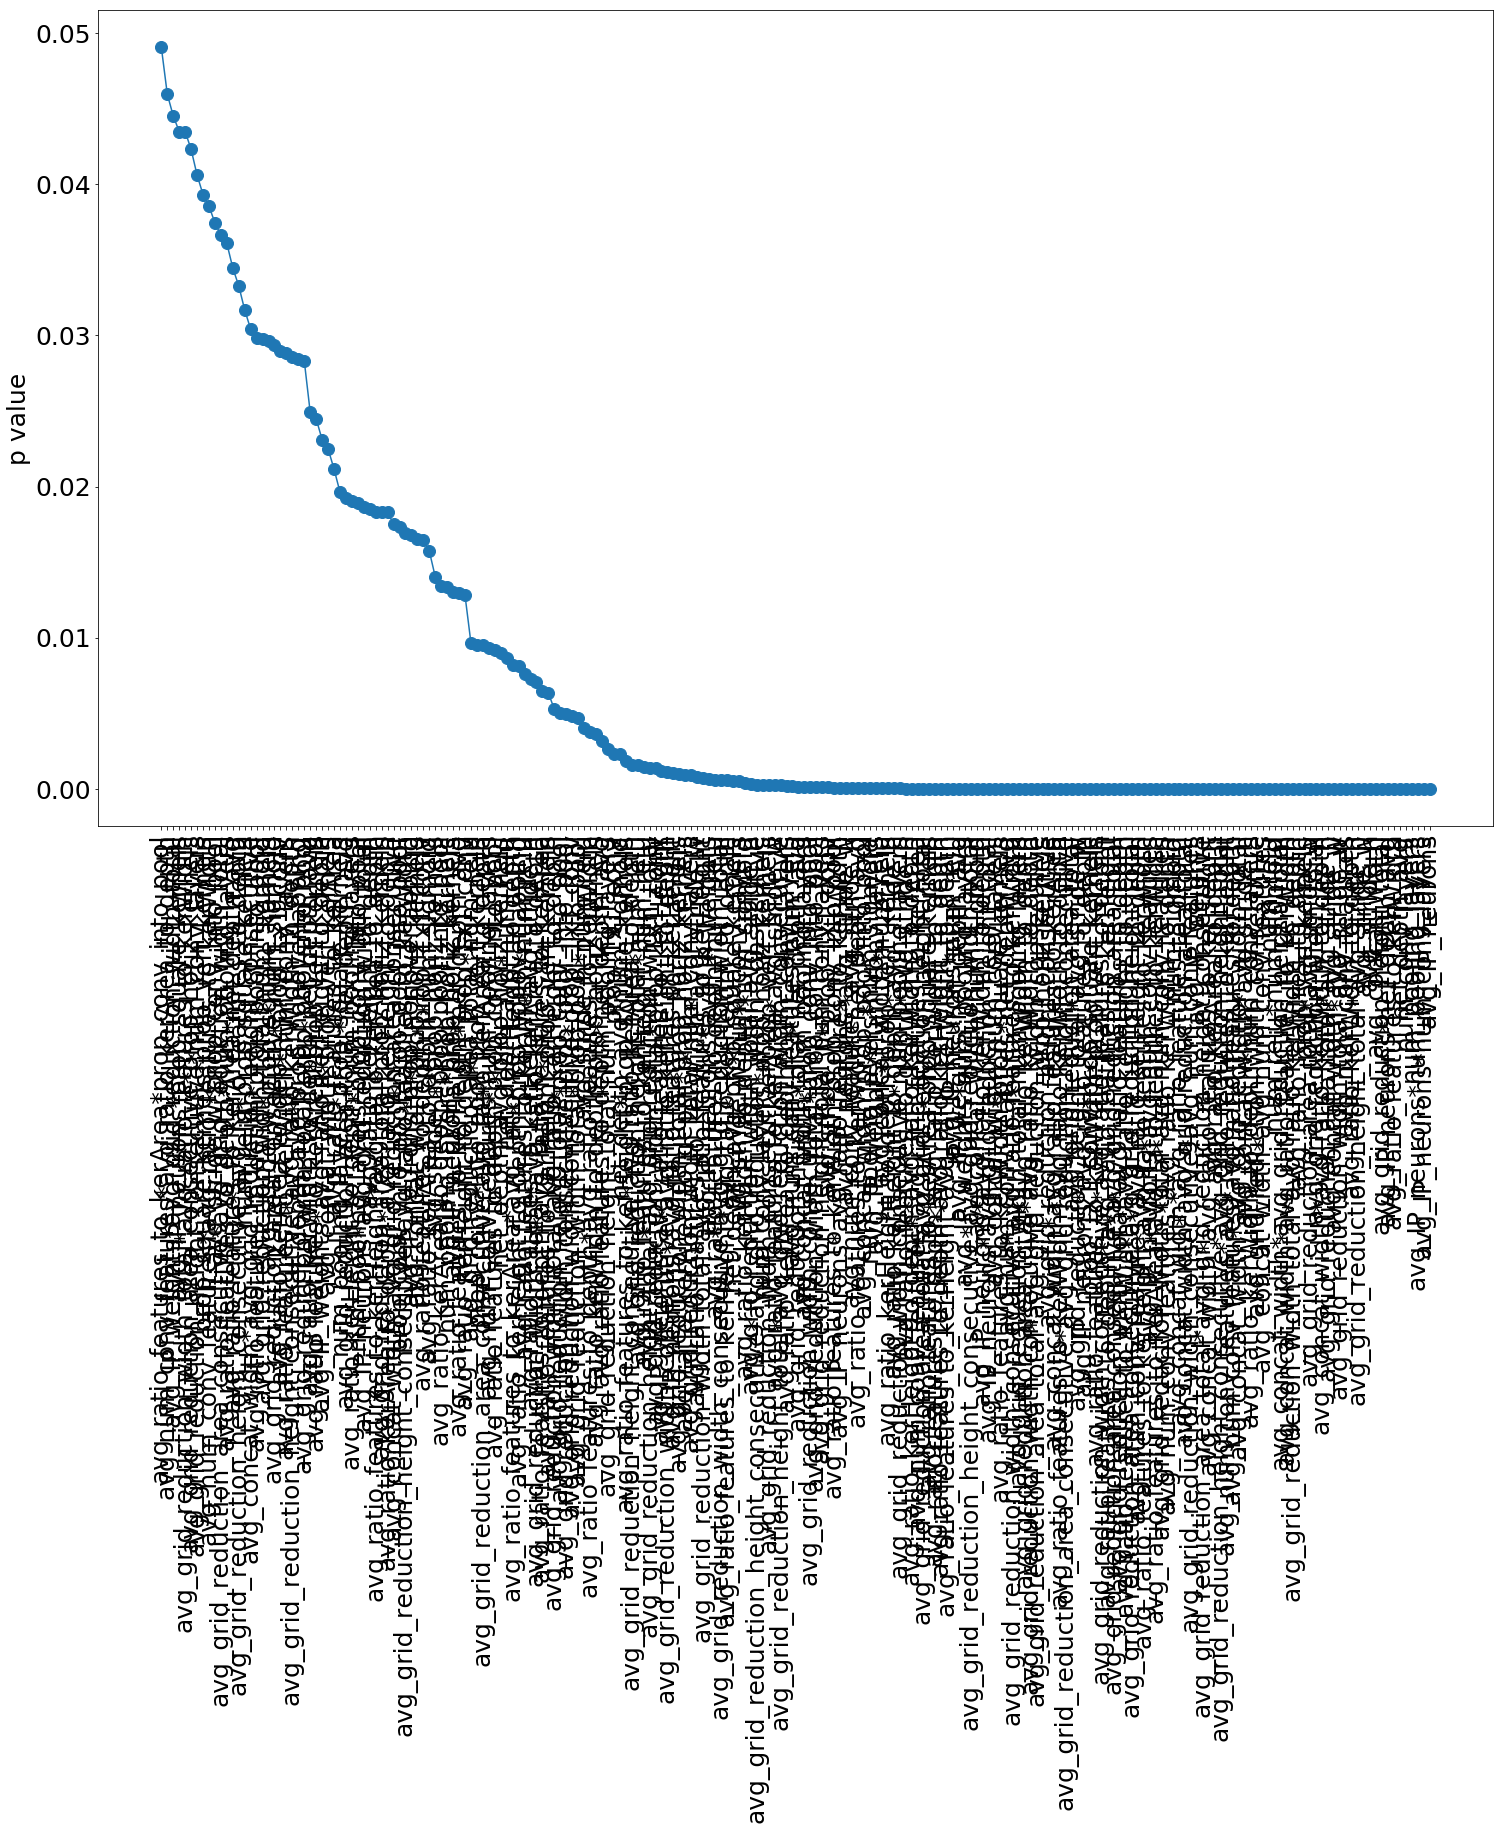

In [20]:
#Plot the sorted p-values
sorted_p_values = important_p.sort_values(by = "P>|t|", ascending = False)

#Position for x axis
pos = np.arange(sorted_p_values.shape[0]) + .5

#Plotting
fig = plt.figure(figsize = [25,15])
plt.plot(pos, sorted_p_values["P>|t|"], '-o', markersize = 12)
plt.xticks(pos, sorted_p_values.index, rotation = "vertical", fontsize = 25)
plt.yticks(fontsize=25)
plt.ylabel("p value", fontsize = 25)
plt.show()


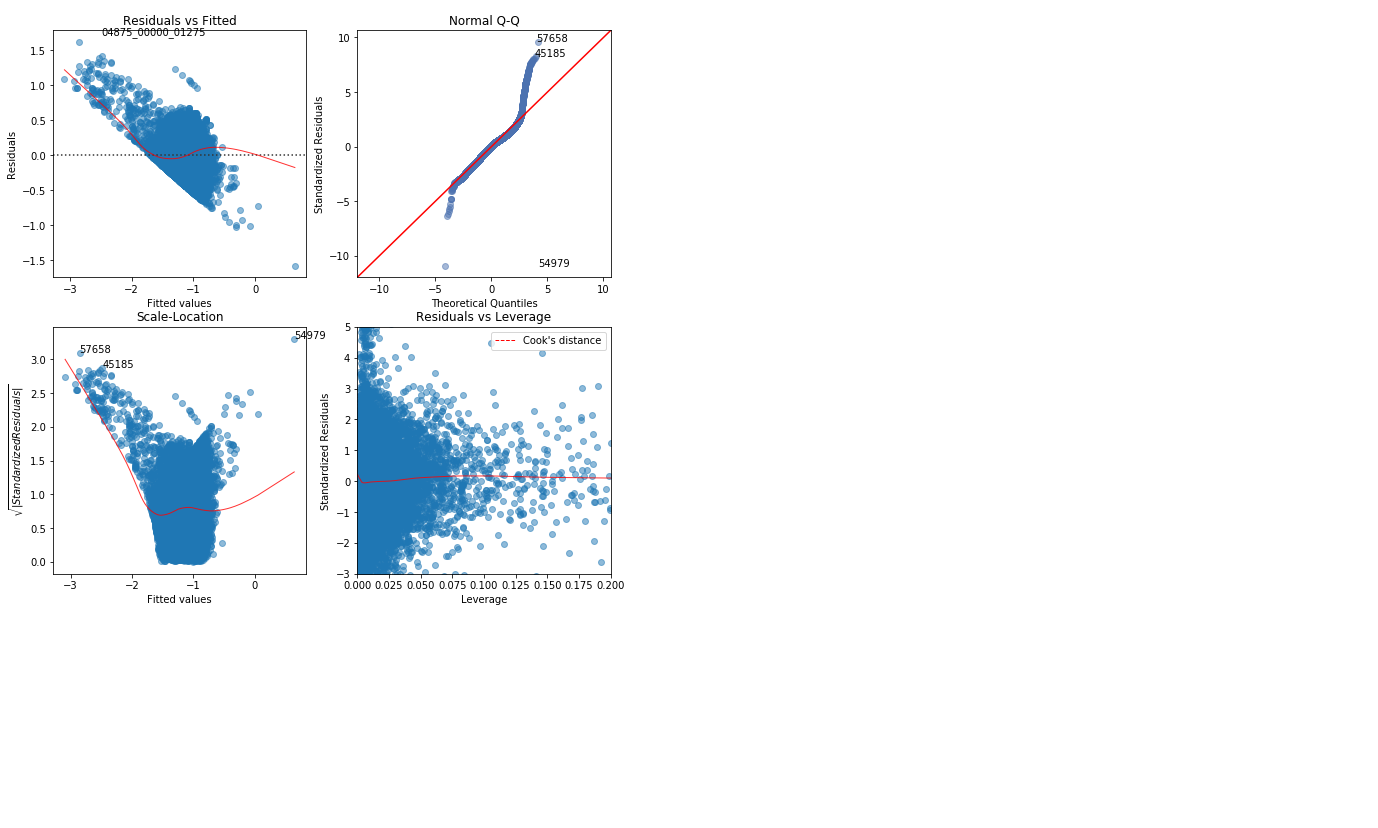

In [17]:
#Might be used to analyse the linear model
regression_residual_plots(results,'transformed_accuracy',df, size = [10,10])

In [21]:
print(float(results.f_pvalue))

0.0
